In [1]:
import src.view.pnl_view as pnlview
from multiprocessing import Pool, Process, Manager, cpu_count
from src.core.logger import Logger
from src.core.stopwatch import Stopwatch
from src.core.stopwatch_logger import StopwatchLogger
from src.synthetic_book_merger import SyntheticBookMerger
from src.synthetic_security_loader import SyntheticSecurityLoader
import src.sniper_opp_loader
from src.sniper_opp_loader import SniperOppLoader
from src.core.domain.book import get_book_level_changes
from src.core.domain.book import to_price_changes_only

from src.view import data_view as dview
from src.view.opp_view import OppView, to_opp_view, display_opp_view
from src.view.cell_view import CellView
from src.view.color import Color, Colors, WebColors
from src.pcap_location_params import PCapLocationParams
from src.core.postgres_connection import PostgresConnection
from src.view.cell_view import CellView
from src.market_date import *

import math
import pandas as pd
import numpy as np
import sqlite3
import time
import matplotlib.pyplot as plt
import os.path

# pandarallel.initialize(progress_bar=True, use_memory_fs=True)
pd.options.display.width = 920
pd.options.display.max_columns = 500
# pd.options.display.max_rows = 220
# pd.options.display.max_rows = 263
pd.options.display.max_rows = 320

In [807]:
print('hey')

hey


In [ ]:
sql_conn = sqlite3.connect('/home/john/spartan_store/sim/sim.sqlite')
run = pd.read_sql('select * from run', sql_conn)
trade_win = pd.read_sql('select * from trade_win_short', sql_conn)
trade_win = pd.merge(trade_win, run[['run_id', 'market_date']], on='run_id')
trade_win['market_date'] = trade_win['market_date'].astype('datetime64')

,run_id,sid,start_eid,start_t,stop_t,min_tr_p,max_tr_p,dbid_p,dbid_eid,dbid_t,dask_p,dask_eid,dask_t,mbid_p,mbid_eid,mbid_t,mask_p,mask_eid,mask_t,last_tr_p,last_tr_eid,last_tr_t,market_date
1,2,3067,5272,1617573606392498225,1.617574e+18,17279.0,17282.0,17000.0,17462.0,1.617574e+18,0.0,0.0,0.000000e+00,17273.0,17462.0,1.617574e+18,0.0,0.0,0.0,17282.0,17462.0,1.617574e+18,2021-04-04
19,3,3067,26695,1617661834974536345,1.617662e+18,17269.0,17278.0,17048.0,30486.0,1.617662e+18,0.0,0.0,0.000000e+00,17273.0,30486.0,1.617662e+18,0.0,0.0,0.0,17278.0,30486.0,1.617662e+18,2021-04-05
20,3,3067,65156,1617664513938372963,1.617665e+18,17269.0,17278.0,17048.0,65156.0,1.617665e+18,0.0,0.0,0.000000e+00,17273.0,65156.0,1.617665e+18,0.0,0.0,0.0,17273.0,65156.0,1.617665e+18,2021-04-05
2,2,3067,129756,1617580238056149073,1.617580e+18,17268.0,17282.0,17267.0,130733.0,1.617580e+18,0.0,0.0,0.000000e+00,17273.0,17462.0,1.617574e+18,0.0,0.0,0.0,17276.0,130776.0,1.617580e+18,2021-04-04
3,2,3067,337070,1617589605529105633,1.617590e+18,17268.0,17282.0,17267.0,130733.0,1.617580e+18,0.0,0.0,0.000000e+00,17273.0,17462.0,1.617574e+18,0.0,0.0,0.0,17276.0,130776.0,1.617580e+18,2021-04-04
21,3,3067,211541,1617669671551828749,1.617670e+18,17269.0,17278.0,17268.0,211541.0,1.617670e+18,0.0,0.0,0.000000e+00,17273.0,65156.0,1.617665e+18,0.0,0.0,0.0,17275.0,211541.0,1.617670e+18,2021-04-05
4,2,3067,356819,1617590460566565171,1.617591e+18,17238.0,17282.0,17267.0,130733.0,1.617580e+18,0.0,0.0,0.000000e+00,17273.0,17462.0,1.617574e+18,0.0,0.0,0.0,17238.0,358631.0,1.617591e+18,2021-04-04
5,2,3067,401506,1617593218179161437,1.617593e+18,17238.0,17282.0,17267.0,130733.0,1.617580e+18,0.0,0.0,0.000000e+00,17273.0,17462.0,1.617574e+18,0.0,0.0,0.0,17250.0,401506.0,1.617593e+18,2021-04-04
23,3,3067,668087,1617673580798155009,1.617674e+18,17269.0,17343.0,17338.0,668088.0,1.617674e+18,0.0,0.0,0.000000e+00,17342.0,618419.0,1.617673e+18,0.0,0.0,0.0,17340.0,643659.0,1.617673e+18,2021-04-05
22,3,3067,618419,1617672928478461541,1.617673e+18,17269.0,17343.0,17338.0,643659.0,1.617673e+18,0.0,0.0,0.000000e+00,17342.0,618419.0,1.617673e+18,0.0,0.0,0.0,17340.0,643659.0,1.617673e+18,2021-04-05


In [ ]:
trade_win['last_tr_eid'] = 

In [820]:
tmp = trade_win.loc[trade_win.market_date == '2021-04-05'].drop(columns=['run_id', 'market_date'])
tmp

,run_id,sid,start_eid,start_t,stop_t,min_tr_p,max_tr_p,dbid_p,dbid_eid,dbid_t,dask_p,dask_eid,dask_t,mbid_p,mbid_eid,mbid_t,mask_p,mask_eid,mask_t,last_tr_p,last_tr_eid,last_tr_t,market_date
19,3,3067,26695,1617661834974536345,1.617662e+18,17269.0,17278.0,17048.0,30486.0,1.617662e+18,0.0,0.0,0.000000e+00,17273.0,30486.0,1.617662e+18,0.0,0.0,0.0,17278.0,30486.0,1.617662e+18,2021-04-05
20,3,3067,65156,1617664513938372963,1.617665e+18,17269.0,17278.0,17048.0,65156.0,1.617665e+18,0.0,0.0,0.000000e+00,17273.0,65156.0,1.617665e+18,0.0,0.0,0.0,17273.0,65156.0,1.617665e+18,2021-04-05
21,3,3067,211541,1617669671551828749,1.617670e+18,17269.0,17278.0,17268.0,211541.0,1.617670e+18,0.0,0.0,0.000000e+00,17273.0,65156.0,1.617665e+18,0.0,0.0,0.0,17275.0,211541.0,1.617670e+18,2021-04-05
22,3,3067,618419,1617672928478461541,1.617673e+18,17269.0,17343.0,17338.0,643659.0,1.617673e+18,0.0,0.0,0.000000e+00,17342.0,618419.0,1.617673e+18,0.0,0.0,0.0,17340.0,643659.0,1.617673e+18,2021-04-05
23,3,3067,668087,1617673580798155009,1.617674e+18,17269.0,17343.0,17338.0,668088.0,1.617674e+18,0.0,0.0,0.000000e+00,17342.0,618419.0,1.617673e+18,0.0,0.0,0.0,17340.0,643659.0,1.617673e+18,2021-04-05
24,3,3067,1135462,1617683587373873621,1.617684e+18,17269.0,17343.0,17338.0,668088.0,1.617674e+18,0.0,0.0,0.000000e+00,17342.0,618419.0,1.617673e+18,0.0,0.0,0.0,17334.0,1135462.0,1.617684e+18,2021-04-05
25,3,3067,1176141,1617684886881922007,1.617685e+18,17269.0,17343.0,17346.0,1176141.0,1.617685e+18,0.0,1176141.0,1.617685e+18,17349.0,1176141.0,1.617685e+18,0.0,0.0,0.0,17334.0,1135462.0,1.617684e+18,2021-04-05
26,3,3067,1214470,1617685980939382427,1.617686e+18,17269.0,17346.0,17346.0,1214488.0,1.617686e+18,0.0,1214808.0,1.617686e+18,17349.0,1176141.0,1.617685e+18,0.0,0.0,0.0,17346.0,1214808.0,1.617686e+18,2021-04-05
27,3,3067,1451605,1617688917232420161,1.617689e+18,17269.0,17380.0,17379.0,1451851.0,1.617689e+18,0.0,1467786.0,1.617689e+18,17379.0,1451851.0,1.617689e+18,0.0,0.0,0.0,17372.0,1467786.0,1.617689e+18,2021-04-05
28,3,3067,1514619,1617689367807088635,1.617690e+18,17269.0,17380.0,17379.0,1451851.0,1.617689e+18,0.0,1542373.0,1.617690e+18,17379.0,1451851.0,1.617689e+18,0.0,0.0,0.0,17361.0,1541201.0,1.617690e+18,2021-04-05


In [521]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [373]:
gcbk = pd.read_feather(PCapLocationParams(360).feather_file_path(date='2021-04-05', name='gc_sgu_bbo'))
gcbk

,eid,t_time,sid,status,implied_matching,bid_p_1,bid_q_1,bid_no_1,ibid_p_1,ibid_q_1,ask_p_1,ask_q_1,ask_no_1,iask_p_1,iask_q_1
0,0,2021-04-05 21:00:00.000000000,8304,NOT_TRADING,False,0.0,0,0,0.0,0,0.0,0,0,0.0,0
1,0,2021-04-05 21:00:00.076130281,18653,NOT_TRADING,False,-36.0,5,1,0.0,0,-35.0,15,2,0.0,0
2,0,2021-04-05 21:00:00.076130281,49277,NOT_TRADING,False,-12.0,439,61,0.0,0,-10.0,415,44,0.0,0
3,0,2021-04-05 21:00:00.000000000,23849,NOT_TRADING,False,-3000.0,3,1,0.0,0,-482.0,3,1,0.0,0
4,0,2021-04-05 21:00:00.000000000,49848,NOT_TRADING,False,0.0,0,0,0.0,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11295695,6842028,2021-04-06 21:00:00.076129885,5568,NOT_TRADING,False,0.0,0,0,NaN,0,0.0,0,0,NaN,0
11295696,6842028,2021-04-06 21:00:00.076129885,1406,NOT_TRADING,False,17360.0,4,1,NaN,0,NaN,0,0,NaN,0
11295697,6842028,2021-04-06 21:00:00.076129885,19720,NOT_TRADING,False,-20.0,85,2,NaN,0,-18.0,60,2,NaN,0
11295698,6842028,2021-04-06 21:00:00.076129885,51659,NOT_TRADING,False,17469.0,1,1,NaN,0,17550.0,2,1,NaN,0


In [422]:
gcm1 = gcbk.loc[gcbk['sid'] == 19317].copy()
gcm1.at[gcm1['ask_q_1'] == 0, 'ask_p_1'] = math.nan
gcm1.at[gcm1['bid_q_1'] == 0, 'bid_p_1'] = math.nan
gcm1['spread'] = gcm1['ask_p_1'] - gcm1['bid_p_1']
gcm1.loc[~gcm1['spread'].isna()]['spread'].quantile(0.068)

70.0

In [520]:
def f(x):
    display(pd.DataFrame(data={'value': [x, x+5]}).plot.line())

slider =ipywidgets.IntSlider(value=1, min=-4, max=40)
# ipywidgets.interact(f, x=slider)
slider.observe(f)
slider

IntSlider(value=1, max=40, min=-4)

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(name='variable', options=['Temperature', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=10)
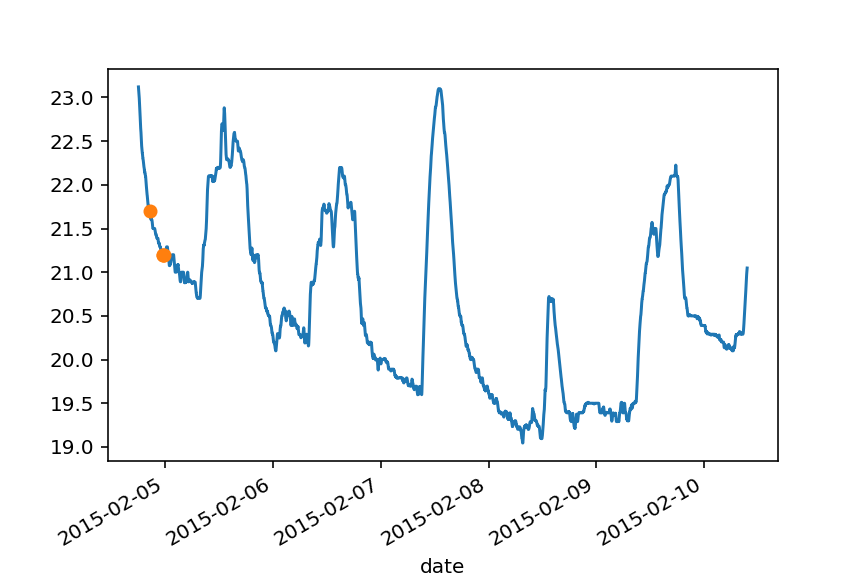

In [508]:
import panel as pn
import panel.widgets as pnw
import pandas as pd;
import numpy as np
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

DATA_URL = "https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/datatraining.txt"
pn.extension()

data = pd.read_csv(DATA_URL)
data['date'] = data.date.astype('datetime64[ns]')
data = data.set_index('date')

variable  = pnw.RadioButtonGroup(name='variable', value='Temperature',
                                 options=list(data.columns))
window  = pnw.IntSlider(name='window', value=10, start=1, end=60)

def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=30, sigma=10, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

@pn.depends(variable, window)
def reactive_outliers(variable, window):
    return find_outliers(variable, window, 10)

widgets   = pn.Column("<br>\n# Room occupancy", variable, window)
occupancy = pn.Row(reactive_outliers, widgets)
occupancy.servable()

In [701]:
# from ipywidgets import interact, interactive, fixed, interact_manual
import datetime
import ipywidgets
from IPython.display import clear_output
# def get_rolling
# gcm1.rolling('5min').apply()
def plot_bbo(start_time, stop_time):
    print(type(start_time))
    print(type(start_time[0]))
    print(type(start_time[1]))
    print(start_time)
    return gcm1[['bid_p_1']].plot.line()
#     res = gcm1.loc[(gcm1['t_time'] >= start_time) & (gcm1['t_time'] <= stop_time)].copy()
#     return res[['bid_p_1', 'ask_p_1']].plot.line()

def plot_bbo_hr(start_time, stop_time):
    print(f'start: {start_time}')
    print(f'stop: {stop_time}')
    return gcm1.loc[(gcm1['t_time'] >= f'2021-04-06 {start_time:02}:00')][['bid_p_1']].plot.line()

def get_date_picker(dates, fmt = None):
    if dates is None or len(dates) == 0:
        raise ValueError(f'Invalid parameter \'dates\': {dates} ')
    opts = [(date.strftime(fmt), date) for date in dates]
    selection_range_slider = ipywidgets.SelectionRangeSlider(
        options=opts,
        index=(0, len(opts) - 1),
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )
    return selection_range_slider

# ipywidgets.interact(plot_bbo, start_time=get_date_picker(), stop_time=get_date_picker())
# output = ipywidgets.interact(
#     plot_bbo_hr,
#     start_time=ipywidgets.IntSlider(value=2, min=2, max=9, step=1),
#     stop_time=ipywidgets.IntSlider(value=8, min=2, max=9, step=1))
# ipywidgets.interact(plot_bbo, start_time= pd.Timestamp('2021-04-06 02:00'), stop_time= pd.Timestamp('2021-04-06 08:00'))
# start_time_selector = ipywidgets.IntSlider(value=2, min=2, max=9, step=1)

opts=list(range(2, 10))
start_time_selector = widgets.SelectMultiple(
    options=opts,
    value=[opts[1]],
    rows=len(opts),
    description='Variables',
    disabled=False)
output = ipywidgets.Output()
display(start_time_selector)
display(output)

def autorefresh(widg):
    print('hey')
    print(widg)
    start_time = widg['new']
    data = gcm1.loc[(gcm1['t_time'] >= f'2021-04-06 {start_time:02}:00')][['bid_p_1']]
    output.clear_output(wait=True)
    with output:
        ax = data.plot()
        plt.show()

start_time_selector.observe(autorefresh, names='value')
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot


SelectMultiple(description='Variables', index=(1,), options=(2, 3, 4, 5, 6, 7, 8, 9), rows=8, value=(3,))

Output()

In [724]:
from platform import system
def plt_maximize():
    # See discussion: https://stackoverflow.com/questions/12439588/how-to-maximize-a-plt-show-window-using-python
    backend = plt.get_backend()
    cfm = plt.get_current_fig_manager()
    if backend == "wxAgg":
        cfm.frame.Maximize(True)
    elif backend == "TkAgg":
        if system() == "win32":
            cfm.window.state('zoomed')  # This is windows only
        else:
            cfm.resize(*cfm.window.maxsize())
    elif backend == 'QT4Agg':
        cfm.window.showMaximized()
    elif callable(getattr(cfm, "full_screen_toggle", None)):
        if not getattr(cfm, "flag_is_max", None):
            cfm.full_screen_toggle()
            cfm.flag_is_max = True
    else:
        raise RuntimeError("plt_maximize() is not implemented for current backend:", backend)

In [806]:
# imports
import bqplot

from ipywidgets import interactive
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib
from matplotlib import pyplot as plt

import ipywidgets as widgets
from IPython.display import display

output = widgets.Output()
timespan_selector = get_date_picker(
    pd.date_range(datetime.datetime(2021, 4, 6, 2), datetime.datetime(2021, 4, 6, 9), freq='min'), fmt=' %H:%M ')

series_selector = widgets.SelectMultiple(
    options=['bid_p_1', 'ask_p_1'],
    value=['bid_p_1', 'ask_p_1'],
    rows=2,
    description='Variables')

display(series_selector)
display(timespan_selector)
display(output)

errors = []
echo = []
def multiplot(x):
    try:
        start = timespan_selector.value[0]
        stop = timespan_selector.value[1]
        data = gcm1.loc[(gcm1['t_time'] >= start) & (gcm1['t_time'] <= stop)][['t_time'] + list(series_selector.value)]
#         data = gcm1.loc[(gcm1['t_time'] >= start) & (gcm1['t_time'] <= stop)]
#         print(data.info())
        print(gcm1['t_time'].min())
        print(gcm1['t_time'].max())
        output.clear_output(wait=True)
        with output:
            data.plot(kind='line', x='t_time', y=None, ylabel='price', figsize=(50,10), xlim=(start, stop), ylim=(166000, 179900))
#             plt.axis([gcm1['t_time'].min(), gcm1['t_time'].max(), 166000, 179000])
#             plt.figure()
#             mng = plt.get_current_fig_manager()
#             mng.window.showMaximized()
            plt.show()
#             display(data)
    except Exception as e:
        errors.append(e)


multiplot({'new': timespan_selector.value})
timespan_selector.observe(multiplot, names='value')
series_selector.observe(multiplot, names='value')

SelectMultiple(description='Variables', index=(0, 1), options=('bid_p_1', 'ask_p_1'), rows=2, value=('bid_p_1'…

SelectionRangeSlider(description='Dates', index=(0, 420), layout=Layout(width='500px'), options=((' 02:00 ', T…

Output()

2021-04-05 21:00:00
2021-04-06 16:41:41.664666369


In [762]:
print(errors)

[KeyError(('bid_p_1', 'ask_p_1'))]


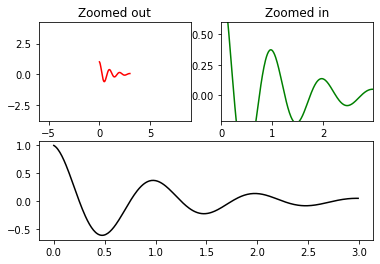

In [641]:
import numpy as np
import matplotlib.pyplot as plt


def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.01)

ax1 = plt.subplot(212)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1), 'k')

ax2 = plt.subplot(221)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t1, f(t1), 'r')
ax2.set_title('Zoomed out')

ax3 = plt.subplot(222)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1), 'g')
ax3.set_title('Zoomed in')

plt.show()

interactive(children=(Dropdown(description='a', options=('Variable X', 'Variable Y', 'Variable Z'), value='Var…

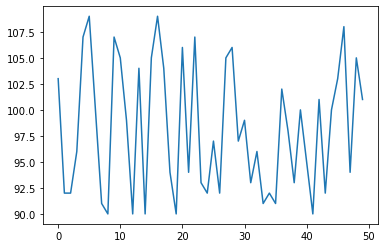

In [543]:
# imports
%matplotlib inline

from ipywidgets import interactive
import pandas as pd
import numpy as np
# from jupyterthemes import jtplot

# Sample data
np.random.seed(123)
rows = 50
dfx = pd.DataFrame(np.random.randint(90,110,size=(rows, 1)), columns=['Variable X'])
dfy = pd.DataFrame(np.random.randint(25,68,size=(rows, 1)), columns=['Variable Y'])
dfz = pd.DataFrame(np.random.randint(60,70,size=(rows, 1)), columns=['Variable Z'])

df = pd.concat([dfx,dfy,dfz], axis = 1)
#jtplot.style()

import ipywidgets as widgets
from IPython.display import display

def multiplot(a):
    opts = df.columns.values
    df.loc[:, a].plot()

interactive_plot = interactive(multiplot, a=['Variable X', 'Variable Y', 'Variable Z'])
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [399]:
gcm1 = gcbk.loc[gcbk['sid'] == 19317].copy()
gcm1.at[gcm1['ask_q_1'] == 0, 'ask_p_1'] = math.nan
gcm1.at[gcm1['bid_q_1'] == 0, 'bid_p_1'] = math.nan
# gcm1.loc[gcm1['ask_q_1'] == 0]
gcm1.iloc[[gcm1['ask_p_1'].argmin(), gcm1['bid_p_1'].argmax()]]
# print(gcm1['ask_p_1'].min())
# gcm1

,eid,t_time,sid,status,implied_matching,bid_p_1,bid_q_1,bid_no_1,ibid_p_1,ibid_q_1,ask_p_1,ask_q_1,ask_no_1,iask_p_1,iask_q_1
2760175,1967138,2021-04-06 07:08:02.273797073,19317,READY_TO_TRADE,True,173230.0,9,1,0.0,0,173280.0,9,1,0.0,0
1950568,1443178,2021-04-06 06:01:15.274539731,19317,READY_TO_TRADE,True,174320.0,9,1,0.0,0,174990.0,6,1,0.0,0


In [378]:
from src.core.domain.security_loader import load_security
tmp = load_security(360, date='2021-04-25')
tmp.loc[tmp['symbol'] == 'SGUM1']

,sid,symbol,expiration,sec_type,cme_sec_type,sec_group,asset,implied_matching,match_algo,display_factor,cash,tick_size,min_price,n_legs,segment_id
3765,19317,SGUM1,2021-06-28 06:15:00,FUTURE,FUT,AG,SGU,True,F,0.01,32.150002,10.0,10.0,0,76


In [435]:
bbo.bid.max() - bbo.ask.min()

-9359.0

In [434]:
bbo = pd.read_feather(PCapLocationParams(360).feather_file_path(name='synthetic_book_40', date='2021-04-25'))
bbo['bid'] = bbo['bid_p_1']
bbo['ask'] = bbo['ask_p_1']
bbo = bbo.drop(columns=['bid_p_1', 'ask_p_1'])
bbo = to_price_changes_only(bbo, bid='bid', ask='ask')
bbo

,eid,t_time,id,symbol,bid_q_1,bid_p_2,bid_q_2,bid_p_3,bid_q_3,ask_q_1,ask_p_2,ask_q_2,ask_p_3,ask_q_3,bid,ask,delta_bid,delta_ask,bid_change,ask_change
0,211671,2021-04-26 00:55:34.198320911,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,4,NaN,0,NaN,0,NaN,201099.0,NaN,0.0,False,True
4,211777,2021-04-26 00:55:35.984341607,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,4,NaN,0,NaN,0,NaN,201100.0,NaN,0.0,False,True
9,211841,2021-04-26 00:55:36.107982211,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,1,201100.0,3,NaN,0,NaN,201099.0,NaN,0.0,False,True
14,211976,2021-04-26 00:55:41.428751625,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,False,True
15,213554,2021-04-26 00:56:40.113125041,40,+SGUJ1 +GCJ1,2,188776.0,1,NaN,0,0,NaN,0,NaN,0,188876.0,NaN,-1.0,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77306,1924143,2021-04-26 07:25:10.583740451,40,+SGUJ1 +GCJ1,1,189870.0,2,NaN,0,3,NaN,0,NaN,0,190071.0,203274.0,1.0,0.0,True,False
77307,1924148,2021-04-26 07:25:10.583930083,40,+SGUJ1 +GCJ1,1,189870.0,2,NaN,0,3,NaN,0,NaN,0,190070.0,203274.0,0.0,1.0,True,False
77308,1924182,2021-04-26 07:25:10.750825643,40,+SGUJ1 +GCJ1,1,189870.0,2,NaN,0,1,203274.0,2,NaN,0,190070.0,203273.0,0.0,0.0,False,True
77312,1924240,2021-04-26 07:25:10.832425595,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,2,203274.0,1,NaN,0,NaN,203273.0,NaN,0.0,True,False


In [52]:
from enum import Enum

class Foo(Enum):
    A = 1
    B = 2


1


In [130]:
bid = bbo['bid']
bid.loc[bid >191000]

27753     191041.0
27754     191041.0
27758     191040.0
27759     191040.0
27769     191040.0
            ...   
117038    191011.0
117047    191011.0
117048    191012.0
117075    191012.0
117076    191012.0
Name: bid, Length: 20037, dtype: float32

In [246]:
df = pd.DataFrame({'foo': [pd.Timedelta('5s')]})
df['bar'] = df['foo'] / pd.Timedelta('1s')
df

,foo,bar
0,0 days 00:00:05,5.0


In [366]:
bbo['bid'].max()
bbo['ask'].min()

165543.0

In [363]:
import src.core.domain.side
import src.core.activator
import importlib
importlib.reload(src.core.domain.side)
importlib.reload(src.core.activator)
from src.core.domain.side import Side

def fmt_rolling_avg(side, win):
    return f'{side}_avg_{win}'

def fmt_rolling_avg_crosses(side, win):
    return f'{fmt_rolling_avg(side, win)}_crosses'

class RollingAvgCalculator:
    def __init__(self, count = 0):
        self.count = count
        self.total_len = 0

    def get_rolling_avg_crosses(self, df, side, avg_side, win):
        avg_side_col = fmt_rolling_avg(avg_side, win)
        delta = df[side] - df[avg_side_col]
        def impl(x):
            self.count += 1
            self.total_len += len(x)
            avg = x.iloc[0]
#             x = df.loc[x.index]
    #         print(type(x))
    #         print(type(df))
#             avg = df[avg_side].shift().iloc[0]
            rv = len(x.loc[(x >= avg) != (x.shift() >= avg)])
            return rv
        print(count)
        return df[side].rolling(win).apply(impl)
    #     return pd.DataFrame({f'{side}_{avg_side}_{win}_crosses': delta.rolling(win).apply(lambda x: len(x.loc[])})
    #     return df[rcol].rolling(win).apply(lambda x: len(x.loc[(x[side] <= x[avg_side].values[0]) != (x[side].shift() <= x[avg_side].values[0])]))

def with_rolling_crosses(df, win='5s'):
    for side in ['bid', 'ask']:
        s = Side.from_mkt_name(side)
#         print(s.other_side().mkt_name())
        opp_side = Side.from_mkt_name(side).other_side().mkt_name()
        rcol = fmt_rolling_avg(side, win)
        df[rcol] = df[side].rolling(win).mean()
    return df


# get_rolling_avg(bbo.set_index('t_time').sort_index(), 'bid', '5min')
rac = RollingAvgCalculator()
# df = bbo.set_index(bbo['t_time'].apply(lambda x: x.value).rename('t_time_us')).sort_index()
df = bbo.set_index('t_time').sort_index()
def get_time_blocks(x, freq):
    freq = src.core.activator.astype(freq, pd.Timedelta)
    ordinal_x = x - x.iloc[0]
    return ordinal_x / freq.value

df['bid_ask'] = list(zip(df['bid'], df['ask']))
def count_crosses(x):
    fbid = x['last_rbid']
    fask = x['last_rask']
    return pd.DataFrame({'bid_ask_crosses': [x['bid'].max()], 'ask_min': [x['ask'].min()]})
df['last_rbid'] = df[['bid']].rolling('5s').mean().shift()
df['last_rask'] = df[['ask']].rolling('5s').mean().shift()
# df.groupby(get_time_blocks(df, '5s')).apply(lambda x: len(x))
# idx = df.index
# pd.Series(index=idx, data=df.reset_index()['t_time'])
# pd.Series(data=df.reset_index()['t_time'].values, index=df.index)
# pd.Series(df.reset_index()['t_time'], index=idx)
# df['blah'] = df.reset_index()['t_time']
# df
df['time_blocks'] =pd.Series(get_time_blocks(df.reset_index()['t_time'], '5min').values, index=df.index)
df = df.groupby('time_blocks').apply(count_crosses)
# df.iloc[pd.Timedelta('4h'):pd.Timedelta('4h') + pd.Timedelta('2min'),:]
df
# print(df['ask'].min())
# print(df['bid'].max())
# print(df['bid'].max() - df['bid'].min())
# print(df['ask'].max() - df['ask'].min())
# df['bid_ask'].rolling('5s').apply()
# df = pd.DataFrame({'res': rac.get_rolling_avg_crosses(with_rolling_crosses(bbo.set_index('t_time').sort_index()).head(1000), 'bid', 'bid', '5s')})
# print(rac.count)
# print(rac.total_len)
# df
# df
# to_price_changes_only(bbo.rename(columns={'bid': 'bid_p_1', 'ask': 'ask_p_1'})).head(100)

,,bid_ask_crosses,ask_min
time_blocks,,,
0 days 00:00:00,0,154826.0,165543.0
0 days 00:00:00.000000001,0,155393.0,166305.0
0 days 00:00:00.000000002,0,155535.0,166279.0
0 days 00:00:00.000000003,0,155554.0,166379.0
0 days 00:00:00.000000004,0,155535.0,166352.0
0 days 00:00:00.000000005,0,155434.0,166295.0
0 days 00:00:00.000000006,0,155469.0,166320.0
0 days 00:00:00.000000007,0,155452.0,166300.0
0 days 00:00:00.000000008,0,155378.0,166235.0


In [361]:
bbo.iloc[0:50]

,eid,t_time,id,symbol,bid_q_1,bid_p_2,bid_q_2,bid_p_3,bid_q_3,ask_q_1,ask_p_2,ask_q_2,ask_p_3,ask_q_3,bid,ask,delta_bid,delta_ask,bid_change,ask_change
0,211671,2021-04-26 00:55:34.198320911,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,4,NaN,0,NaN,0,NaN,201099.0,NaN,0.0,False,True
4,211777,2021-04-26 00:55:35.984341607,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,4,NaN,0,NaN,0,NaN,201100.0,NaN,0.0,False,True
9,211841,2021-04-26 00:55:36.107982211,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,1,201100.0,3,NaN,0,NaN,201099.0,NaN,0.0,False,True
14,211976,2021-04-26 00:55:41.428751625,40,+SGUJ1 +GCJ1,0,NaN,0,NaN,0,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,False,True
15,213554,2021-04-26 00:56:40.113125041,40,+SGUJ1 +GCJ1,2,188776.0,1,NaN,0,0,NaN,0,NaN,0,188876.0,NaN,-1.0,NaN,True,False
16,213576,2021-04-26 00:56:43.485847459,40,+SGUJ1 +GCJ1,1,188876.0,1,188776.0,1,0,NaN,0,NaN,0,188877.0,NaN,0.0,NaN,True,False
21,213643,2021-04-26 00:56:45.474526607,40,+SGUJ1 +GCJ1,2,188776.0,1,NaN,0,0,NaN,0,NaN,0,188876.0,NaN,-1.0,NaN,True,False
22,213737,2021-04-26 00:56:46.642602683,40,+SGUJ1 +GCJ1,1,188876.0,1,188776.0,1,0,NaN,0,NaN,0,188877.0,NaN,1.0,NaN,True,False
23,213749,2021-04-26 00:56:46.642867341,40,+SGUJ1 +GCJ1,2,188776.0,1,NaN,0,0,NaN,0,NaN,0,188876.0,NaN,-1.0,NaN,True,False
24,213812,2021-04-26 00:56:49.364957303,40,+SGUJ1 +GCJ1,2,188776.0,1,NaN,0,0,NaN,0,NaN,0,188877.0,NaN,0.0,NaN,True,False


In [50]:
import numba
merged_bbo = bbo.set_index('t_time').sort_index()
merged_bbo[['rbid', 'rask']] = merged_bbo.rolling('5s')[['bid', 'ask']].mean()
merged_bbo['bid_minus_rask'] = merged_bbo['bid'] - merged_bbo['rask']
merged_bbo['ask_minus_rbid'] = merged_bbo['ask'] - merged_bbo['rbid']
# merged_bbo = merged_bbo.set_index(merged_bbo.index.drop_duplicates())
merged_bbo = merged_bbo[~merged_bbo.index.duplicated(keep='first')]

def rolling_apply(df, windows, apply_fn):
    def impl(x):
        return apply_fn(df.loc[x.index])
    return windows[df.columns[0:1]].apply(impl, raw=False)

def count_ravg_crosses(x):
    rbid = x['rbid'][0]
    rask = x['rask'][0]
#     bid_crosses = (x > 0) != (x.shift(-1) > 0)
#     nbid_crosses = bid_crosses.sum()
#     return nbid_crosses
    bid_crosses = (x['bid'] > rask) != (x.shift(-1)['bid'] > rask)
    nbid_crosses = bid_crosses.sum()
#     ask_crosses = (x['ask_minus_rbid'] > 0) != (x.shift(-1)['ask_minus_rbid'] > 0)
#     nask_crosses = ask_crosses.sum()
#     ask_crosses = (x['ask_minus_rbid'] > 0) != (x.shift(-1)['ask_minus_rbid'] > 0)
#     nask_crosses = ask_crosses.sum()
    return len(x)
#     return pd.DataFrame({'n_bid_crosses': [nbid_crosses]})

def opp_side(side):
    side_pairs = [
        ('buy', 'sell'),
        ('bid', 'ask'),
    ]
    for b, s in side_pairs:
        if side == b:
            return s
        if side == s:
            return b
    return None


def count_ravg_crosses_lambda(side):
    def impl(x):
        rside_mkt = x[f'r{side}']
        crosses = (x[side] > )
# merged_bbo[['nbid_rask_crosses', 'nask_rbid_crosses']] = merged_bbo.rolling('5s').apply(count_ravg_crosses)
rbbo = merged_bbo.iloc[100000:100100].rolling('5s')
bid_crosses = rolling_apply(merged_bbo, rbbo, count_ravg_crosses)
bid_crosses
# ask_crosses = rbbo[['bid']].apply(count_ravg_crosses, raw=False)

# merged_bbo.rolling('5s')
# merged_bbo

,eid
t_time,
2021-04-06 14:30:05.675428457,1.0
2021-04-06 14:30:05.675730423,2.0
2021-04-06 14:30:05.675839811,3.0
2021-04-06 14:30:05.676048197,4.0
2021-04-06 14:30:05.676175117,5.0
2021-04-06 14:30:05.684415809,6.0
2021-04-06 14:30:05.731957257,7.0
2021-04-06 14:30:06.020802445,8.0
2021-04-06 14:30:06.021321051,9.0


In [76]:
len(merged_bbo.index.unique())

100227

In [26]:
tmp = merged_bbo.reset_index().drop(columns='sid').sort_values('eid').set_index('eid')
tmp.sort_index().fillna(method='ffill').loc[100000:100900]
# tmp.set_index(tmp.index.drop_duplicates())
# merged_bbo.drop_duplicates(subset=['bid_left'])

,bid_left,ask_left,bid_right,ask_right
eid,,,,
100049,17275.0,17279.0,0.0,0.0
100085,17274.0,17279.0,0.0,0.0
100090,17274.0,17278.0,0.0,0.0
100113,17271.0,17278.0,0.0,0.0
100130,17271.0,17277.0,0.0,0.0
100147,17271.0,17276.0,0.0,0.0
100197,17271.0,17276.0,166200.0,185400.0
100210,17271.0,17276.0,166200.0,185370.0
100213,17272.0,17276.0,0.0,0.0


In [10]:
len(bbo.loc[bbo['symbol'] == 'GCJ1'])

100227

In [150]:
sguj1_bbo.loc[99000:100600]

,sid,t_time,status,implied_matching_x,bid,ibid_p_1,ibid_q_1,ask,iask_p_1,iask_q_1,symbol,asset,sec_group,implied_matching_y,dbid,dask,bid_change,ask_change,sym
eid,,,,,,,,,,,,,,,,,,,
99029,1432,2021-04-05 23:51:45.515923329,READY_TO_TRADE,True,166300.0,166300.0,3,185460.0,185460.0,3,SGUJ1,SGU,AG,True,30.0,0.0,True,False,SGUJ1
99129,1432,2021-04-05 23:51:45.517174669,READY_TO_TRADE,True,166270.0,166270.0,3,185460.0,185460.0,3,SGUJ1,SGU,AG,True,0.0,30.0,True,False,SGUJ1
99156,1432,2021-04-05 23:51:45.518117317,READY_TO_TRADE,True,166270.0,166270.0,3,185430.0,185430.0,3,SGUJ1,SGU,AG,True,10.0,0.0,False,True,SGUJ1
99552,1432,2021-04-05 23:51:49.438743465,READY_TO_TRADE,True,166260.0,166260.0,3,185430.0,185430.0,3,SGUJ1,SGU,AG,True,30.0,0.0,True,False,SGUJ1
99637,1432,2021-04-05 23:51:49.440037303,READY_TO_TRADE,True,166230.0,166230.0,3,185430.0,185430.0,3,SGUJ1,SGU,AG,True,0.0,30.0,True,False,SGUJ1
99659,1432,2021-04-05 23:51:49.440544561,READY_TO_TRADE,True,166230.0,166230.0,3,185400.0,185400.0,3,SGUJ1,SGU,AG,True,30.0,0.0,False,True,SGUJ1
100197,1432,2021-04-05 23:51:58.724780105,READY_TO_TRADE,True,166200.0,166200.0,3,185400.0,185400.0,3,SGUJ1,SGU,AG,True,0.0,30.0,True,False,SGUJ1
100210,1432,2021-04-05 23:51:58.725107409,READY_TO_TRADE,True,166200.0,166200.0,3,185370.0,185370.0,3,SGUJ1,SGU,AG,True,-30.0,0.0,False,True,SGUJ1
100339,1432,2021-04-05 23:51:58.728845573,READY_TO_TRADE,True,166230.0,166230.0,3,185370.0,185370.0,3,SGUJ1,SGU,AG,True,0.0,-10.0,True,False,SGUJ1


In [154]:
gcj1_bbo

,sid,t_time,status,implied_matching_x,bid,ibid_p_1,ibid_q_1,ask,iask_p_1,iask_q_1,symbol,asset,sec_group,implied_matching_y,dbid,dask,bid_change,ask_change,sym
eid,,,,,,,,,,,,,,,,,,,
2916,3067,2021-04-05 22:00:00.000000000,READY_TO_TRADE,True,17274.0,17274.0,10,17281.0,17281.0,1,GCJ1,GC,GC,True,0.0,0.0,True,True,GCJ1
2944,3067,2021-04-05 22:00:00.068640963,READY_TO_TRADE,True,17274.0,17274.0,6,17280.0,17280.0,1,GCJ1,GC,GC,True,0.0,0.0,False,True,GCJ1
3372,3067,2021-04-05 22:00:00.092101357,READY_TO_TRADE,True,17274.0,17274.0,6,17279.0,17279.0,1,GCJ1,GC,GC,True,0.0,0.0,False,True,GCJ1
3546,3067,2021-04-05 22:00:00.105667159,READY_TO_TRADE,True,17274.0,17274.0,6,17280.0,17280.0,4,GCJ1,GC,GC,True,0.0,0.0,False,True,GCJ1
3566,3067,2021-04-05 22:00:00.109538733,READY_TO_TRADE,True,17275.0,17275.0,1,17280.0,17280.0,4,GCJ1,GC,GC,True,0.0,0.0,True,False,GCJ1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6842019,3067,2021-04-06 20:59:59.702786439,READY_TO_TRADE,True,17427.0,17427.0,4,17430.0,17430.0,10,GCJ1,GC,GC,True,0.0,1.0,True,False,GCJ1
6842020,3067,2021-04-06 20:59:59.702815383,READY_TO_TRADE,True,17427.0,17427.0,4,17429.0,17429.0,1,GCJ1,GC,GC,True,0.0,-1.0,False,True,GCJ1
6842021,3067,2021-04-06 20:59:59.704029843,READY_TO_TRADE,True,17427.0,17427.0,4,17430.0,17430.0,10,GCJ1,GC,GC,True,-1.0,0.0,False,True,GCJ1


In [160]:
blah = pd.DataFrame(data={'foo': [1.0, math.nan, 2.0]})
blah.fillna(method='ffill')

,foo
0,1.0
1,1.0
2,2.0


In [192]:
get_synth_bbo(gcj1_bbo, sguj1_bbo).loc[38100:40000]

,bid_left,ask_left,bid_right,ask_right
eid,,,,
38103,17278.0,17283.0,NaN,NaN
38122,17279.0,17283.0,NaN,NaN
38135,17279.0,17284.0,NaN,NaN
38136,17279.0,17283.0,NaN,NaN
38146,17279.0,17284.0,NaN,NaN
38191,17279.0,17283.0,NaN,NaN
38196,17278.0,17283.0,NaN,NaN
38199,17279.0,17283.0,NaN,NaN
38206,17278.0,17283.0,NaN,NaN


In [190]:
tmp.fillna(method='ffill').loc[38100:40000]

,gcj1_bid,gcj1_ask,sguj1_bid,sguj1_ask
eid,,,,
38103,17278.0,17283.0,NaN,NaN
38122,17279.0,17283.0,NaN,NaN
38135,17279.0,17284.0,NaN,NaN
38136,17279.0,17283.0,NaN,NaN
38146,17279.0,17284.0,NaN,NaN
38191,17279.0,17283.0,NaN,NaN
38196,17278.0,17283.0,NaN,NaN
38199,17279.0,17283.0,NaN,NaN
38206,17278.0,17283.0,NaN,NaN


In [165]:
ser = tmp.copy()
ser = ser.loc[100000:100099]
ser.fillna(method='ffill')

,gcj1_bid,gcj1_ask,sguj1_bid,sguj1_ask
eid,,,,
100049,17275.0,17279.0,NaN,NaN
100085,17274.0,17279.0,NaN,NaN
100090,17274.0,17278.0,NaN,NaN


In [144]:
merged_bbo.set_index('eid').loc[100000:110000,:]

,gcj1_bid,gcj1_ask,sguj1_bid,sguj1_ask
eid,,,,
100049,17275.0,17279.0,166230.0,185400.0
100085,17274.0,17279.0,166230.0,185400.0
100090,17274.0,17278.0,166230.0,185400.0
100113,17271.0,17278.0,166230.0,185400.0
100130,17271.0,17277.0,166230.0,185400.0
100147,17271.0,17276.0,166230.0,185400.0
100213,17272.0,17276.0,166200.0,185370.0
100255,17273.0,17276.0,166200.0,185370.0
100311,17273.0,17277.0,166200.0,185370.0


In [136]:
merged_bbo[100000:100020]

,gcj1_bid,gcj1_ask,sguj1_bid,sguj1_ask
eid,,,,
6833981,17431.0,17434.0,0.0,0.0
6833990,17431.0,17433.0,0.0,0.0
6834035,17430.0,17433.0,0.0,0.0
6834042,17431.0,17433.0,0.0,0.0
6834078,17430.0,17433.0,0.0,0.0
6834139,17430.0,17432.0,0.0,0.0
6834170,17430.0,17433.0,0.0,0.0
6834210,17430.0,17432.0,0.0,0.0
6834230,17429.0,17432.0,0.0,0.0


In [65]:
gcm1_bbo['bid'].mean()

19017.201

In [76]:
sgcq1_bbo['ask'].mean()

31419.549

In [39]:
sec = load_security(360, '2021-06-01')
# sec.loc[(sec['asset'] == 'GC') | (sec['asset'] == 'SGC')].sort_values('symbol')
sec.loc[sec['symbol'].str.match('(SGCM1|GCM1)$')].sort_values('symbol')

,sid,symbol,expiration,sec_type,cme_sec_type,sec_group,asset,implied_matching,match_algo,display_factor,cash,tick_size,min_price,n_legs,segment_id
1538,100440,GCM1,2021-06-28 17:30:00,FUTURE,FUT,GC,GC,True,F,0.10,100.0,1.0,1.0,0,76
5417,19117,SGCM1,2021-06-28 06:15:00,FUTURE,FUT,AG,SGC,True,F,0.01,1000.0,5.0,5.0,0,76


In [ ]:
sgc[]